In [1]:
%pylab inline
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import sk_dsp_comm.sigsys as ssd
import scipy.signal as signal
import imp # for module reloading
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX
%Image('fname.png',width='90%')

**Import Extra Modules**

In [3]:
import scipy.special as special
import sk_dsp_comm.digitalcom as dc
import sk_dsp_comm.synchronization as pll

# PCM Encoding and Decoding

In [ ]:
dc.PCM_encode()
dc.PCM_decode()
dc.AWGN_chan()

# Tasks Part I

## Task 1a
When working with PCM_encode() you need to understand that the dynamic range is limited just like with an ADC.

To be clear on the impact of this behavior design an input signal, $x[n]$, that is a ramp that sweeps linearly from -2 to +2 over 400 steps. In Python this can be constructed and plotted as follows once, the missing line is completed.

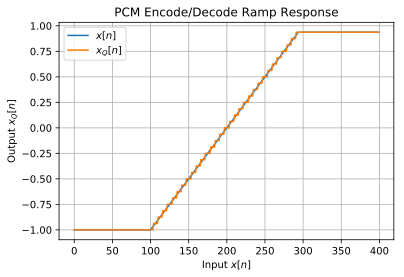

In [8]:
figure(figsize=(6,4))
Nb = 5
n = arange(0,400)
# Complete ******
x = ?
#*************
# Add clipping to x
x = x.clip(?,?)
#*************
xbits = dc.PCM_encode(x,Nb)
xq = dc.PCM_decode(xbits,Nb)
plot(n,x)
plot(n,xq)
title(r'PCM Encode/Decode Ramp Response')
xlabel(r'Input $x[n]$')
ylabel(r'Output $x_Q[n]$')
legend((r'$x[n]$',r'$x_Q[n]$'),loc='best')
grid();

## Task 1b
To avoid the twos complement wrap-around it is better to impose clipping. The function `x.clip()` from Numpy is useful here. Add this to the above code cell.

## Test with Speech File

In [9]:
N = 100000; # number of speech samples to process
fs,m1 = ssd.from_wav('OSR_uk_000_0050_8k.wav')
m1 = m1[:N]

In [31]:
xe = dc.PCM_encode(m1,8)
xer = dc.AWGN_chan(xe,20)
m1_hat = dc.PCM_decode(xer,8)

In [32]:
y_demod = m1_hat
ssd.to_wav('yp2.wav',8000,y_demod)
Audio('yp2.wav')

# Tasks Part II

In [15]:
#dc.NRZ_bits(N_bits, Ns, pulse='rect', alpha=0.25, M=6)
xbb1,b,d = dc.NRZ_bits(10000,16,'src')
n = arange(0,len(xbb1))
# Translate baseband to fc1/fs = 4.0/16
# Relative to Ns = 16 samps/bit & Rb = 1 bps
xc1 = xbb1*exp(1j*2*pi*4.0/16*n)

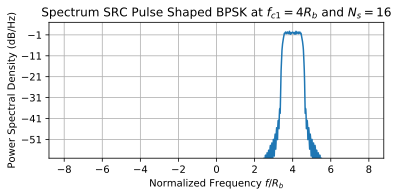

In [16]:
figure(figsize=(6,2.5))
psd(xc1,2**10,16);
ylim([-60,5])
xlabel(r'Normalized Frequency $f/R_b$')
title(r'Spectrum SRC Pulse Shaped BPSK at $f_{c1} \
      = 4R_b$ and $N_s = 16$');

## BPSK Simulation Example

In [17]:
Nstart = 22000; # start here
Nsamp = 20000 # number of sample to process
fs,m0 = ssd.from_wav('OSR_uk_000_0050_8k.wav')
m0 = m0[Nstart:Nstart+Nsamp]

In [27]:
# Set the Eb/N0 value in dB for the channel
EbN0_dB = 100
Ns = 16 # number of samples per bit; keep fixed

# Choose the random bits or PCM encoded speech
# Uncomment the line below to select random bits
# Enter the number of bits simulated, here 10000
Nbits = 10000
x,b,a_in = dc.NRZ_bits(Nbits,Ns,'src')
#
# Uncomment the following two lines to select encoded speech
#a_in = dc.PCM_encode(m0,8)
#x,b = dc.NRZ_bits2(a_in,Ns,'src')

# AWGN channel set via EbNo_dB at top
y = dc.cpx_AWGN(x,EbN0_dB,Ns)

# Introduce frequency error into the baseband BPSK signal
# setting Df = 0.012 makes actual Df = 0.012*Rb
n = arange(0,len(x))
Df = 0.012;
y *= exp(1j*2*pi*Df/Ns*n) # Df = 0.012*Rb or 1.2% of Rb

# Incorporate adjacent channel signals by
# uncommenting the next five lines
#f_adj = 1.4
#x_lo,b,d_lo = dc.NRZ_bits(len(a_in),Ns,'src')
#x_hi,b,d_hi = dc.NRZ_bits(len(a_in),Ns,'src')
#y = y + x_lo*exp(-1j*2*pi*f_adj/Ns*n) \
#      + x_hi*exp(1j*2*pi*f_adj/Ns*n)

# Matched filter
z = signal.lfilter(b,1,y)
# Sample MF output at once per bit
# The third argument controls the sampling phase or offset mod Ns
zd = ssd.downsample(z,Ns,0)

# Carrier phase tracking
# DD carrier phase sync: 2<=>BPSK, 0.05=loop BW/Rb,0.70=loop damping
zz,a_hat,e_phi,theta_hat = pll.DD_carrier_sync(zd,2,0.05,0.707)

# Estimate the bit error probability (BEP)
Nbits,Nerrors = dc.BPSK_BEP(2.*a_in-1,a_hat.real)
print('BEP: Nbits = %d, Nerror = %d, Pe_est = %1.3e' % \
      (Nbits, Nerrors, Nerrors/Nbits))

# Calculate the corresponding theoretical BEP, but
# note this is ideal as the carrier phase tracking is
# not modeled.
Pe_thy = 1/2*special.erfc(sqrt(10**(EbN0_dB/10)))
print('Pe_thy = %1.3e' % Pe_thy)

kmax =  0, taumax = 12
BEP: Nbits = 9988, Nerror = 0, Pe_est = 0.000e+00
Pe_thy = 0.000e+00


In [23]:
# Decode a_hat if it is speech data; correct for
# the 12 bit delay through the transceiver
m0_hat = dc.PCM_decode(1-(1+a_hat[12:-4].real)//2,8)
ssd.to_wav('m0_hat.wav',8000,m0_hat)
Audio('m0_hat.wav')

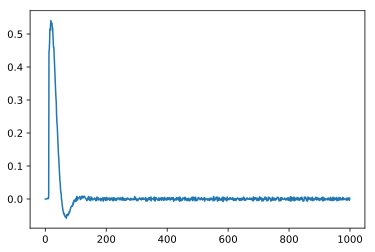